<a href="https://colab.research.google.com/github/GrinddMaster/My_Grind/blob/main/Transfer_VGG_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

andrewmvd_retinal_disease_classification_path = kagglehub.dataset_download('andrewmvd/retinal-disease-classification')
grindmaster79_retinal_lables_path = kagglehub.dataset_download('grindmaster79/retinal-lables')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ThreadPoolExecutor
import plotly.graph_objects as go
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.applications import VGG16
clear_output(wait=True)
#IMPORTANT NOTE--- Proper results are shown in the report
#Improper results here are due to draft failing to save
# Screen shots were taken before refreshing the page and losing the results

   ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  CME  PTCR  \
0   1             1   1     0   0   0    0     0     1    0  ...    0     0   
1   2             1   0     0   0   0    0     0     0    0  ...    0     0   
2   3             1   0     0   0   0    0     0     0    0  ...    0     0   
3   4             1   0     0   0   0    0     0     0    0  ...    0     0   
4   5             1   0     0   0   0    0     0     0    0  ...    0     0   

   CF  VH  MCA  VS  BRAO  PLQ  HPED  CL  
0   0   0    0   0     0    0     0   0  
1   0   0    0   0     0    0     0   0  
2   0   0    0   0     0    0     0   0  
3   0   0    0   0     0    0     0   0  
4   0   0    0   0     0    0     0   0  

[5 rows x 47 columns]
(3200, 47)


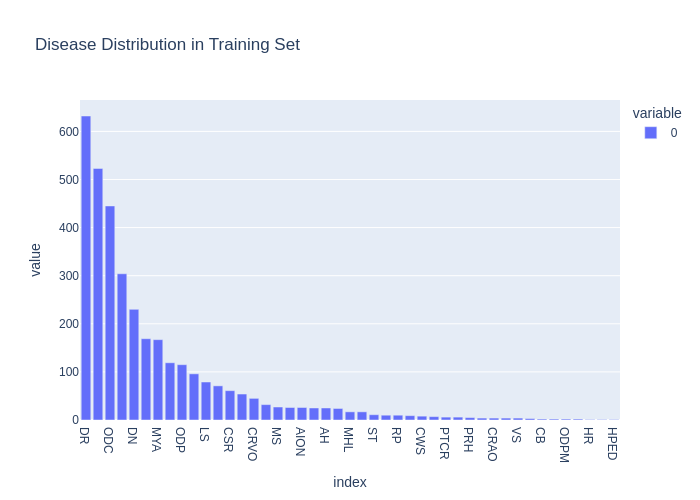

In [ ]:
data = pd.read_csv('/kaggle/input/retinal-lables/Labels.csv')
Eval_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
Test_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
Train_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
print(data.head())

Eval_set_path = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation'
Test_set_path = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test'
Train_set_path = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training'

print(data.shape)
disease_counts = data.iloc[:, 2:].sum().sort_values(ascending=False)
fig = px.bar(disease_counts, title="Disease Distribution in Training Set")
fig.show(renderer = "png")


#pip install -U kaleido
#Restart kernel GoTo -> Run -> Restart & ClearSession

In [ ]:
def load_Elabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Eval_labels_path[Eval_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Telabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Test_labels_path[Test_labels_path['ID']==id]
        if not matching_row.empty:
            row = Eval_labels_path[Eval_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
def load_Trlabels(img_id):
    labels = []
    for id in img_id['ID']:
        matching_row = Train_labels_path[Train_labels_path['ID']==id]
        if not matching_row.empty:
            row = Train_labels_path[Train_labels_path['ID'] == id].iloc[0]
            labels.append(row['Disease_Risk'])
        else:
            print(f'{id} isnt found')
    return np.array(labels)
Eval_labels = load_Elabels(Eval_labels_path)
print(Eval_labels.shape)
Test_labels = load_Telabels(Test_labels_path)
print(Test_labels.shape)
Train_labels = load_Trlabels(Train_labels_path)
print(Train_labels.shape)

Ytrain = np.concatenate((Eval_labels,Test_labels,Train_labels))
print(Ytrain.shape)
#Now all the images and Lables are in Xtrain

(640,)
(640,)
(1920,)
(3200,)


In [ ]:
testgen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

In [ ]:
def load_images(img_id,img_path):#this function returns all the images and lables in one big array
    images = []
    for id in img_id['ID']:
        full_img_path = os.path.join(img_path, f"{id}.png")
        if os.path.exists(full_img_path):
            img = cv2.imread(full_img_path)
            if img is not None:
                img = cv2.resize(img,(246,246))
                images.append(img)
    return np.array(images)

Eval_images = load_images(Eval_labels_path,Eval_set_path)
Test_images = load_images(Test_labels_path,Test_set_path)
Train_images = load_images(Train_labels_path,Train_set_path)
Xtrain = np.concatenate((Eval_images,Test_images,Train_images))
print(Xtrain.shape)
#Now all the iamges and Lables are in Xtrain

(3200, 246, 246, 3)


In [ ]:
Xtrain = Xtrain/255.0 #Normalize the data.
augmented_test = testgen.flow(Test_images,Test_labels,shuffle=True)


In [ ]:
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true,dtype='float32')
    y_pred = K.cast(y_true,dtype='float32')

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))

In [ ]:
kf = KFold(n_splits=5)
fold_no = 1
history_list = []
for train_index, val_index in kf.split(Xtrain):
    Xtrain_fold,Xval_fold = Xtrain[train_index],Xtrain[val_index]
    Ytrain_fold,Yval_fold = Ytrain[train_index],Ytrain[val_index]
    print(f'Training fold {fold_no}...')

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(246, 246, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(47, activation='relu')(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False


    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy',Precision(name='precision'),Recall(name='recall'),f1_score])

    history=model.fit(Xtrain_fold, Ytrain_fold, epochs=50, validation_data=(Xval_fold, Yval_fold))
    history_list.append(history)
    fold_no += 1


Training fold 1...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.7554 - f1_score: 1.0000 - loss: 0.6054 - precision: 0.7804 - recall: 0.9369 - val_accuracy: 0.7906 - val_f1_score: 1.0000 - val_loss: 0.3882 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.7797 - f1_score: 1.0000 - loss: 0.4975 - precision: 0.7873 - recall: 0.9855 - val_accuracy: 0.8203 - val_f1_score: 1.0000 - val_loss: 0.3832 - val_precision: 0.8210 - val_recall: 0.9881
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.7847 - f1_score: 1.0000 - loss: 0.4640 - precision: 0.8070 - recall: 0.9553 - val_accuracy: 0.8422 - val_f1_score: 1.0000 - val_loss: 0.3496 - val_precision: 0.8510 - val_recall: 0.9704
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.8104 - f1_score: 1.0000 - loss: 0.4511 - precision: 0.8280 - recall: 0.9614 - val_accuracy: 0.8172 - val_f1_score: 1.0000 - val_loss: 0.4138 - val_precisio

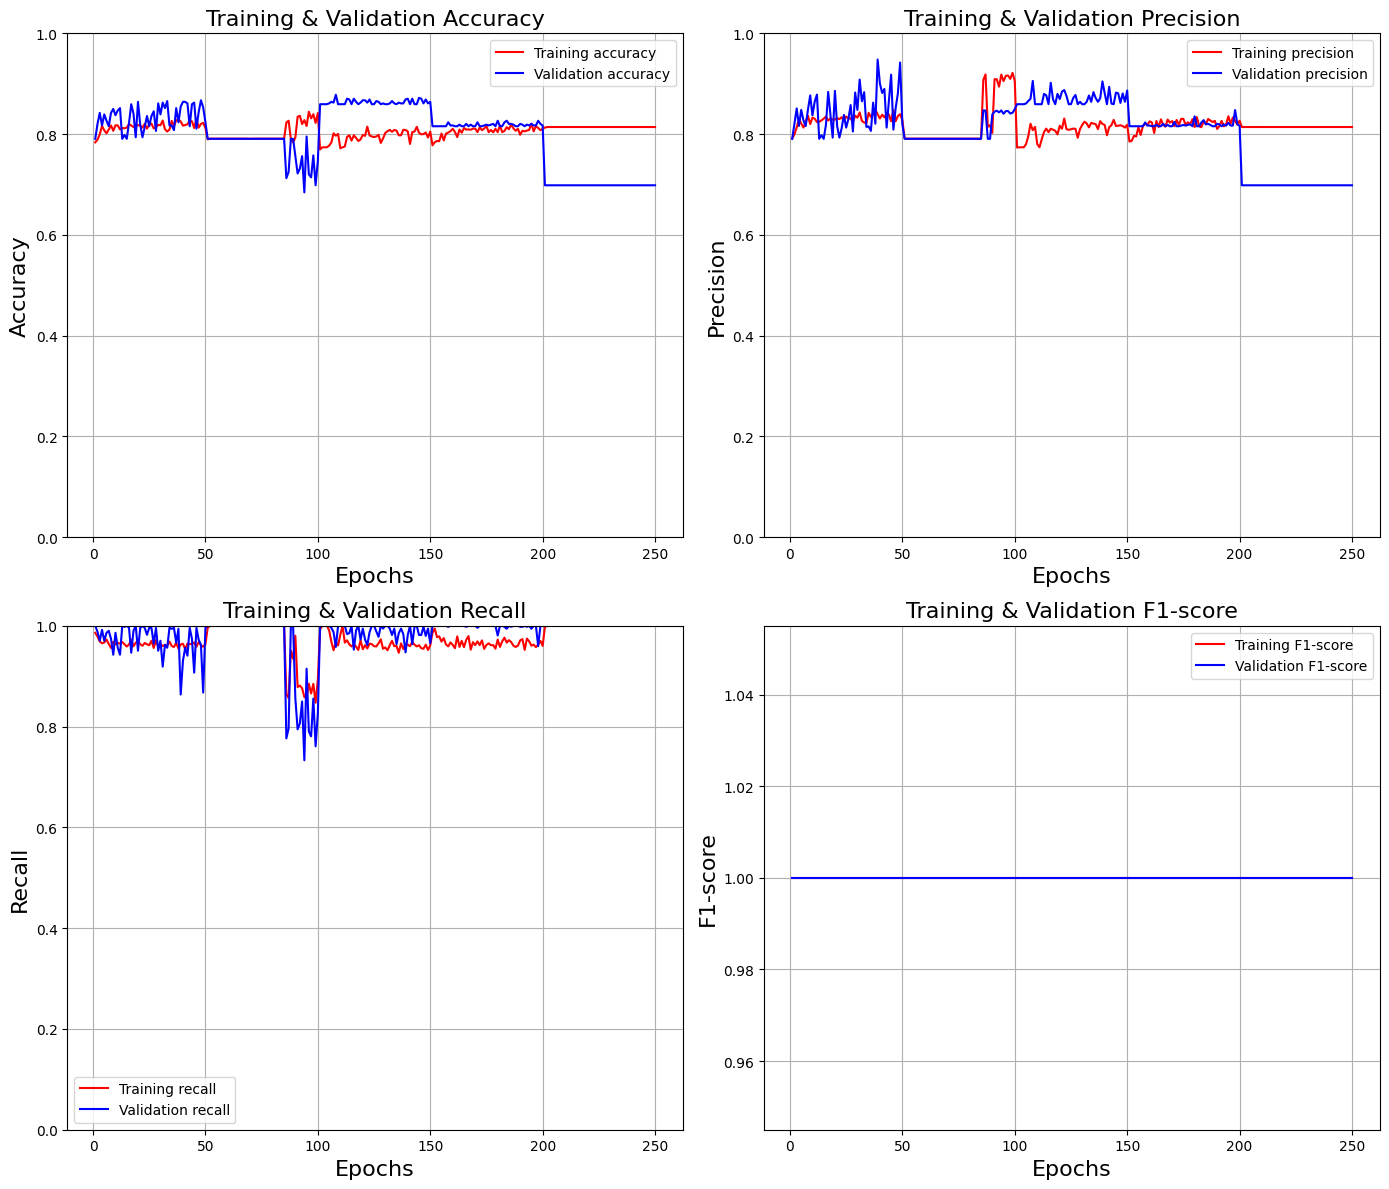

In [ ]:
history_dict = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': [], 'f1_score': [], 'val_f1_score': []}

for history in history_list:
    for key in history_dict.keys():
        if key in history.history:
            history_dict[key].extend(history.history[key])
        else:
            print(f'Key {key} not found')

epochs = range(1, len(history_dict['loss']) + 1)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

#  accuracy vs Epochs
ax[0, 0].plot(epochs, history_dict['accuracy'], 'r', label='Training accuracy')
ax[0, 0].plot(epochs, history_dict['val_accuracy'], 'b', label='Validation accuracy')
ax[0, 0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0, 0].set_xlabel('Epochs', fontsize=16)
ax[0, 0].set_ylabel('Accuracy', fontsize=16)
ax[0, 0].legend()
ax[0, 0].grid(True)
ax[0, 0].set_ylim(0.0, 1.0)   # Adjusted Y-axis scale

#  precision vs Epochs
ax[0, 1].plot(epochs, history_dict['precision'], 'r', label='Training precision')
ax[0, 1].plot(epochs, history_dict['val_precision'], 'b', label='Validation precision')
ax[0, 1].set_title('Training & Validation Precision', fontsize=16)
ax[0, 1].set_xlabel('Epochs', fontsize=16)
ax[0, 1].set_ylabel('Precision', fontsize=16)
ax[0, 1].legend()
ax[0, 1].grid(True)
ax[0, 1].set_ylim(0.0, 1.0)   # Adjusted Y-axis scale

#  recall vs Epochs
ax[1, 0].plot(epochs, history_dict['recall'], 'r', label='Training recall')
ax[1, 0].plot(epochs, history_dict['val_recall'], 'b', label='Validation recall')
ax[1, 0].set_title('Training & Validation Recall', fontsize=16)
ax[1, 0].set_xlabel('Epochs', fontsize=16)
ax[1, 0].set_ylabel('Recall', fontsize=16)
ax[1, 0].legend()
ax[1, 0].grid(True)
ax[1, 0].set_ylim(0.0, 1.0)   # Adjusted Y-axis scale

#  F1-score vs Epochs
ax[1, 1].plot(epochs, history_dict['f1_score'], 'r', label='Training F1-score')
ax[1, 1].plot(epochs, history_dict['val_f1_score'], 'b', label='Validation F1-score')
ax[1, 1].set_title('Training & Validation F1-score', fontsize=16)
ax[1, 1].set_xlabel('Epochs', fontsize=16)
ax[1, 1].set_ylabel('F1-score', fontsize=16)
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = (model.predict(augmented_test) > 0.5).astype("int32")

print("Recall:", accuracy_score(Test_labels, y_pred))
print("Classification Report:")
print(classification_report(Test_labels, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step
Recall: 0.790625
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.79      1.00      0.88       506

    accuracy                           0.79       640
   macro avg       0.40      0.50      0.44       640
weighted avg       0.63      0.79      0.70       640



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



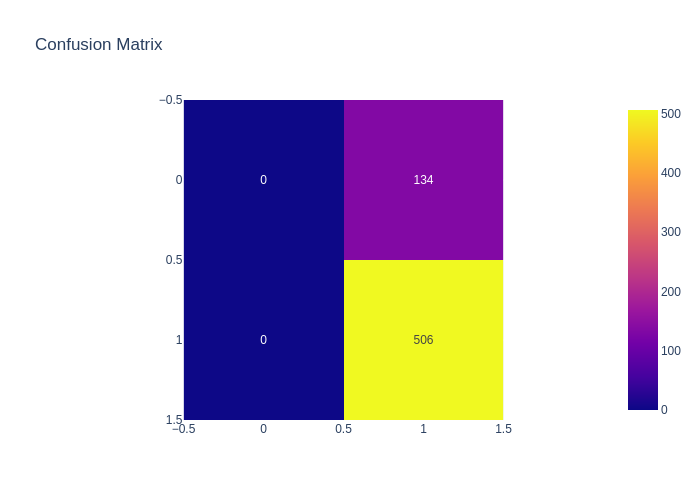

In [ ]:
cm = confusion_matrix(Test_labels, y_pred)
fig = px.imshow(cm, text_auto=True, title="Confusion Matrix")
fig.show(renderer = "png")

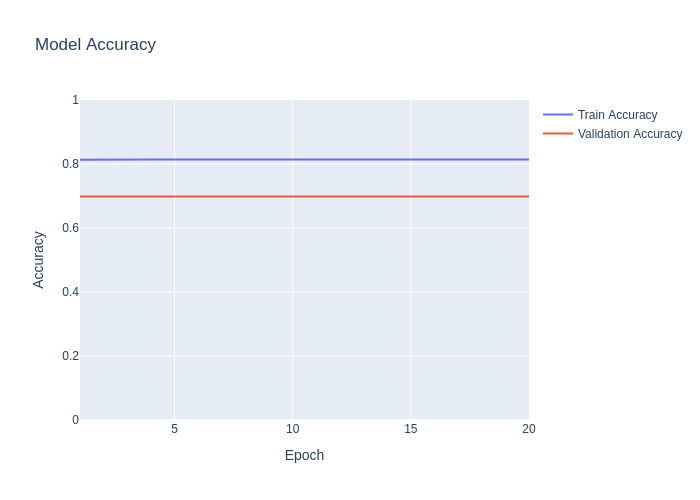

In [ ]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy',yaxis=dict(range=[0.0, 1.0]))
fig.show(renderer="png")

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, 21)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='png',yaxis=dict(range=[0.0, 1.0]))